In [1]:
import pandas as pd
import numpy as np
from doc_bd import Manage_db
import json
import os
import mysql.connector
from mysql.connector import errorcode
import re
import urllib3 
import time
import warnings
warnings.filterwarnings('ignore')
urllib3.disable_warnings()
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree

In [3]:
sql = Manage_db(database = 'lop2test', host = 'localhost', user='root', password='')

client = MongoClient("localhost", 27017)
db = client['lop2test']
submissions_lop = db['submissions']

#df_class.loc[df['id_class'] == 'f2dd7bef-5b5d-4cb3-9efa-aa8652af0605']
id_class = 'e378c59f-e815-4a41-95fc-e95e4432a34c'
#pd_data = pd.DataFrame([id_class], columns = ['id_class'])
condition = "WHERE class_id = 'e378c59f-e815-4a41-95fc-e95e4432a34c'"
df_submission = sql.search(table='submission')
list_quest_subm = df_submission.drop(['ip', 'id', 'environment','hitPercentage','timeConsuming','createdAt','type','language', 'answer', 'char_change_number', 'user_id', 'lesson_id', 'class_id', 'test_id'], axis=1).drop_duplicates()
df_submission_class = sql.search(table='submission', condition=condition)
df_lop_lists = sql.search(table='listQuestions')

df_lop_tests = sql.search(table='test')

df_class = sql.search(table='class')
df_quest = sql.search(table='question')

users_class = sql.search(table='classHasUser')
tag = sql.search(table='tag')
quest_tag = sql.search(table='questionHasTag')
df_list_q = sql.search(table='listHasQuestion')

In [4]:
tag.columns.values[0] ='tag_id'
list_class = df_submission_class['listQuestions_id'].drop_duplicates().reset_index(name='id')
a = df_lop_lists.columns.tolist()
df_list_class = pd.DataFrame(columns = a)

for i in range(list_class.count().values[0]):
    for a in range(df_lop_lists.count().values[0]):
        if list_class['id'][i] == df_lop_lists['id'][a]:
            b = dict(df_lop_lists.loc[a])
            df_list_class = df_list_class.append(b, ignore_index=True)
df_list_class.columns.values[0] = 'listQuestions_id'

test_class = df_submission_class['test_id'].drop_duplicates().reset_index(name='id')
a = df_lop_tests.columns.tolist()
df_test_class = pd.DataFrame(columns = a)

for i in range(test_class.count().values[0]):
    for a in range(df_lop_tests.count().values[0]):
        if test_class['id'][i] == df_lop_tests['id'][a]:
            b = dict(df_lop_tests.loc[a])
            df_test_class = df_test_class.append(b, ignore_index=True)
df_test_class.columns.values[0] = 'test_id'

quest_class = df_submission_class['question_id'].drop_duplicates().reset_index(name='id')
a = df_quest.columns.tolist()
df_quest_class = pd.DataFrame(columns = a)

for i in range(quest_class.count().values[0]):
    for a in range(df_quest.count().values[0]):
        if quest_class['id'][i] == df_quest['id'][a]:
            b = dict(df_quest.loc[a])
            df_quest_class = df_quest_class.append(b, ignore_index=True)
df_quest_class.columns.values[0] = 'question_id'

#verificando o total de questoes cadastrados em listas da turma 
list_name = df_list_class['listQuestions_id'].tolist()
a = df_list_q.columns.tolist()
df_q_l = pd.DataFrame(columns = a)

for i in range(df_list_class.count().values[0]):
    for a in range(df_list_q.count().values[0]):
        if df_list_class['listQuestions_id'][i] == df_list_q['list_id'][a]:
            b = dict(df_list_q.loc[a])
            df_q_l = df_q_l.append(b, ignore_index=True)

subs =[]
for x in submissions_lop.find():
    subs.append(x)
df_class_lop = pd.DataFrame(subs)

list_class = df_class_lop['listQuestions_id'].drop_duplicates().reset_index(name='id')
a = df_lop_lists.columns.tolist()
df_list_lop = pd.DataFrame(columns = a)

for i in range(list_class.count().values[0]):
    for a in range(df_lop_lists.count().values[0]):
        if list_class['id'][i] == df_lop_lists['id'][a]:
            b = dict(df_lop_lists.loc[a])
            df_list_lop = df_list_lop.append(b, ignore_index=True)
df_list_lop.columns.values[0] = 'listQuestions_id'

In [5]:
#aprovados - acima da media
#submissoes da turma

#retirando da df_class_lop todas as turmas do 2020.1
l_classes = df_class_lop['class_id'].drop_duplicates().tolist()
nclasses = []
nclasses.append(l_classes[0])
nclasses.append(l_classes[5])
nclasses.append(l_classes[8])

df_class_lop = df_class_lop.drop( df_class_lop[df_class_lop['class_id']==nclasses[0]].index )
df_class_lop = df_class_lop.drop( df_class_lop[df_class_lop['class_id']==nclasses[1]].index )
df_class_lop = df_class_lop.drop( df_class_lop[df_class_lop['class_id']==nclasses[2]].index )

df_performance = df_class_lop.groupby(['class_id', 'user_id', 'listQuestions_id','question_id'])['hitPercentage'].max().reset_index()
#soma das notas por lista
df_performance = df_performance.groupby(['class_id', 'user_id','listQuestions_id'])['hitPercentage'].sum().reset_index()
#Me traz as porcentagens maximas de acerto por questão
df_performance = df_class_lop.groupby(['class_id', 'user_id','listQuestions_id','question_id'])['hitPercentage'].max().reset_index()
      #Soma as porcentagens de uma lista/prova unica
df_performance = df_performance.groupby(['class_id', 'user_id','listQuestions_id'])['hitPercentage'].sum().reset_index()
      #Renomeando para melhorar entendimento
df_performance.rename(columns={'hitPercentage':'totalHitPercentage'}, inplace = True)
#Listas cadastradas nessa turma
lists = df_class_lop['listQuestions_id'].drop_duplicates().values
#Lista de alunos
df_without_duplicates = df_class_lop.drop_duplicates(subset=['class_id', 'user_id'])

df_prov = pd.DataFrame()
for lista in lists:
    df_users = df_without_duplicates.copy()
    df_users['listQuestions_id'] = lista
    df_prov = df_prov.append(df_users)

df_performance = pd.merge(df_performance,df_prov, on=['class_id', 'user_id','listQuestions_id'], how='outer')#.fillna(0)  
      #Conta quantas questões tem por lista
df_question_data = list_quest_subm.groupby(['listQuestions_id'])['question_id'].count().reset_index(name='totalQuestionslist')
      #Merge
df_performance = df_performance.merge(df_question_data, on = 'listQuestions_id')
    #Média de acerto por lista
df_performance['medialist'] = df_performance['totalHitPercentage'] / df_performance['totalQuestionslist']
      #Convertendo para datetime
df_lop_lists['createdAt'] = pd.to_datetime(df_lop_lists['createdAt'])
      #Criando campo com a data
df_lop_lists['dateList'] = df_lop_lists['createdAt'].dt.date
      #Merge
lists_df = df_list_lop
lists_df.columns.values[0] = 'listQuestions_id'

df_performance = pd.merge(df_performance, lists_df.drop(columns = ['createdAt']), on='listQuestions_id')
    #graph1
    #Número de alunos na turma
    #Media por lista por cada turma
newDf = df_performance
newDf = newDf.groupby(['user_id', 'class_id'])['medialist'].sum().reset_index()
newDf['medialist'] = newDf['medialist'] / lists_df.count().values[0]

newDf['aprovado'] = 2
for a in range(newDf.count().values[0]):
    if newDf['medialist'].values[a]>=50:
        newDf['aprovado'][a]=1
    else:
        newDf['aprovado'][a]=0
        
df_class_lop_t = df_class_lop.sort_values('createdAt')
classes = df_class_lop_t['class_id'].drop_duplicates().tolist()

order_lists = pd.DataFrame(columns = ['class_id', 'listQuestions_id'])
for i in range(len(classes)):
    one_class = df_class_lop_t[df_class_lop_t['class_id']==classes[i]]
    order_lists0 = one_class['listQuestions_id'].drop_duplicates().tolist()
    for a in range(len(order_lists0)):
        b = dict({'class_id':classes[i], 'listQuestions_id':order_lists0[a]})
        order_lists = order_lists.append(b, ignore_index=True)
#oberservar a ordem de saída de cada user para não ter problemas posteriores, 
#por conta da ordem de inserção do 'ateLista' para cada aluno
usersp = df_class_lop_t.drop_duplicates(subset=['class_id', 'user_id']).drop(['_id','id','ip','type', 'environment', 'hitPercentage','timeConsuming','createdAt','language', 'answer', 'char_change_number', 'lesson_id','test_id', 'question_id', 'listQuestions_id'], axis=1)
usersp['ateLista'] = 0

one_class = df_class_lop_t[df_class_lop_t['class_id']==classes[0]]
users = one_class['user_id'].drop_duplicates().tolist()

alunoPclass = pd.DataFrame(columns = ['class_id', 'qtd_user'])
for x in range(len(classes)):
    teste = df_class_lop_t[df_class_lop_t['class_id']==classes[x]]
    teste = teste['user_id'].drop_duplicates()
    teste = teste.count()
    b = dict({'class_id':classes[x], 'qtd_user':teste})
    alunoPclass = alunoPclass.append(b, ignore_index=True)

In [6]:
lista_ate = []
cont = 0
a = usersp.columns.tolist()
newTeste = pd.DataFrame(columns = a)

for i in range(alunoPclass.count().values[0]):
    one_class = df_class_lop_t[df_class_lop_t['class_id']==classes[i]]
    users = one_class['user_id'].drop_duplicates().tolist()
    for y in range(alunoPclass['qtd_user'][i]):
        one_studt = one_class[one_class['user_id']==users[y]]
        qtd_ate_l0 = one_studt['listQuestions_id'].drop_duplicates().tolist()
        maior = 0
        for x in range(len(qtd_ate_l0)):
            order_lists1 = order_lists[order_lists['class_id']==classes[i]]
            order_lists1 = order_lists1['listQuestions_id'].tolist()
            cont=cont+1
            for z in range(len(order_lists1)):
                if qtd_ate_l0[x] == order_lists1[z]:
                    if maior < z:
                        maior = z
        if(users[y]=='fe3c3b36-a1ab-4365-b088-1686cd5177d0'):
            print(maior)
            print(cont)
        b = dict({'class_id':classes[i], 'user_id':users[y], 'ateLista':maior})
        newTeste = newTeste.append(b, ignore_index=True)
usersp = newTeste.copy()

#para verificar por turma
#qtd_ateLista = usersp.groupby(['ateLista', 'class_id'])['user_id'].count().reset_index(name='totalDeAlunosAteLista')
qtd_ateLista = usersp.groupby(['ateLista'])['user_id'].count().reset_index(name='totalDeAlunosAteLista')
qtd_totalAteLista = qtd_ateLista
for x in range(len(qtd_totalAteLista)):
    qtd_totalAteLista['totalDeAlunosAteLista'][x+1]= qtd_totalAteLista['totalDeAlunosAteLista'][x] + qtd_totalAteLista['totalDeAlunosAteLista'][x+1]
    if x==len(qtd_totalAteLista)-2:
        break
usersAteApr = pd.merge(newDf,usersp, on=['user_id', 'class_id'], how='outer')
#erro
aprovs = usersAteApr[usersAteApr['aprovado']==1]
aprAlista = aprovs.groupby(['ateLista'])['aprovado'].count().reset_index(name='totalDeAprAteLista')
ate_Lista = usersp.groupby(['ateLista'])['user_id'].count().reset_index(name='totalDeAlunosAteLista')
porcentAtePlista = usersp.groupby(['ateLista'])['user_id'].count().reset_index(name='totalDeAlunosAteLista')
porcentAtePlista['totalDeAlunosAteLista']=0.0
for x in range(len(ate_Lista)):
    for a in range(len(aprAlista)):
        if ate_Lista['ateLista'][x] == aprAlista['ateLista'][a]:
            porcentAtePlista['totalDeAlunosAteLista'][x] = aprAlista['totalDeAprAteLista'][a] / ate_Lista['totalDeAlunosAteLista'][x]
#salvando todas as submissoes em ordem temporal
df_class_lop_t = df_class_lop.sort_values('createdAt')
#salavndo a quantidade de listas que cada aluno resolveu
usersQtd = df_class_lop_t.groupby(['user_id','listQuestions_id', 'class_id'])['question_id'].count().reset_index(name='qtdLista')
usersQtd = usersQtd.groupby(['user_id', 'class_id'])['listQuestions_id'].count().reset_index(name='qtdLista')
qtd_Lista = usersQtd.groupby(['qtdLista'])['user_id'].count().reset_index(name='totalDeAlunosQtdLista')
porc_qtd_Lista = usersQtd.groupby(['qtdLista'])['user_id'].count().reset_index(name='totalDeAlunosQtdLista')
for a in range(len(qtd_Lista)):
    atual = usersQtd[usersQtd['qtdLista']==a+1]
    cont=0
    total=atual.count().values[0]
    for x in range(total):
        verif_user=newDf[newDf['user_id']==atual['user_id'].iloc[x]]
        if verif_user['aprovado'].values[0]==1:
            cont=cont+1
usersQtdApr = pd.merge(newDf,usersQtd, on=['user_id', 'class_id'], how='outer')
aprovs = usersQtdApr[usersQtdApr['aprovado']==1]
aprPlista = aprovs.groupby(['qtdLista'])['aprovado'].count().reset_index(name='totalDeAprQtdLista')
qtd_Lista = usersQtd.groupby(['qtdLista'])['user_id'].count().reset_index(name='totalDeAlunosQtdLista')
porcentAprPlista = usersQtd.groupby(['qtdLista'])['user_id'].count().reset_index(name='totalDeAlunosQtdLista')
porcentAprPlista['totalDeAlunosQtdLista']=0.0
for x in range(len(qtd_Lista)):
    for a in range(len(aprPlista)):
        if qtd_Lista['qtdLista'][x] == aprPlista['qtdLista'][a]:
#            print(x)
            porcentAprPlista['totalDeAlunosQtdLista'][x] = aprPlista['totalDeAprQtdLista'][a] / qtd_Lista['totalDeAlunosQtdLista'][x]
qtd_ateLista = usersp.groupby(['ateLista'])['user_id'].count().reset_index(name='totalDeAlunosAteLista')

usersQtdApr2 = pd.merge(newDf,usersp, on=['user_id','class_id'], how='outer')
qtd_ate = pd.merge(usersQtd,usersp, on=['user_id','class_id'], how='outer')
usersQtdAte = pd.merge(newDf,qtd_ate, on=['user_id','class_id'], how='outer')

15
1629


In [7]:

#contando o erro por questao acima do tempo zero para prevenir duplo clicke. geralmente, se há cola ou algum problema relacionado, acaba nao sendo um erro na questao
#buscando erros por lista, por aluno
df_class_lop_t['timeInSecounds'] = df_class_lop_t['timeConsuming'].divide(1000).astype(int)

df_without_duplicates = df_class_lop_t[df_class_lop_t["timeInSecounds"] > 0].drop(['language','test_id','environment','timeConsuming','createdAt','timeInSecounds','char_change_number', 'ip', 'type', 'answer', 'lesson_id', 'id'], axis=1)
df_erro = df_without_duplicates[df_without_duplicates["hitPercentage"] == 0]
df_erro = df_erro.groupby(['user_id','class_id','listQuestions_id','question_id'])['hitPercentage'].count().reset_index(name='totalError')
df_erro = df_erro.groupby(['class_id','user_id'])['totalError'].sum()

#buscando quantidade de questoes certas por lista por aluno
df_acerto = df_without_duplicates[df_without_duplicates["hitPercentage"] > 0]
df_acerto = df_acerto.groupby(['class_id','user_id','listQuestions_id','question_id'])['hitPercentage'].count().reset_index(name='totalAcert')
df_acerto = df_acerto.groupby(['class_id','user_id'])['totalAcert'].sum()

#buscando quantidade de questoes que com 100% de acerto por lista por aluno
df_100 = df_without_duplicates[df_without_duplicates["hitPercentage"] == 100].drop_duplicates()
df_100 = df_100.groupby(['class_id','user_id','listQuestions_id','question_id'])['hitPercentage'].count().reset_index(name='acert_100')
df_100 = df_100.groupby(['class_id','user_id'])['acert_100'].sum()

#buscar se o aluno chegou a tirar 100 na questão ou a nota final.
#há mais de um acerto, pois há mais vezes que tentam tirar mais que zero, mas nem sempre chegam no 100
#avaliar a possibilidade de colocar a nota maxima do aluno em coluna

df = pd.merge(df_erro, df_acerto, on=['class_id','user_id'], how='outer')
df = pd.merge(df, df_100, on=['class_id','user_id'], how='outer')
df.replace(np.NaN, 0, inplace = True)
df = pd.merge(df, newDf, on=['class_id','user_id']).drop('medialist', axis=1)

a = df_without_duplicates.drop(['_id', 'hitPercentage', 'listQuestions_id'], axis=1).drop_duplicates()
qtd_qPa = a.groupby(['class_id','user_id'])['question_id'].count().reset_index(name='totalQuest')
media_df = pd.merge(df, qtd_qPa, on=['class_id','user_id'])
media_df['totalError'] = media_df['totalError'] / media_df['totalQuest']
media_df['totalAcert'] = media_df['totalAcert'] / media_df['totalQuest']
media_df['acert_100'] = media_df['acert_100'] / media_df['totalQuest']
df_cont_subm = df_without_duplicates.groupby(['class_id','user_id','listQuestions_id','question_id'])['hitPercentage'].count().reset_index(name='total_subm')
df_cont_subm = df_cont_subm.groupby(['class_id','user_id'])['total_subm'].sum()
media_df1 = pd.merge(df_cont_subm, qtd_qPa, on=['class_id','user_id'])
media_df1['total_subm'] = media_df1['total_subm'] / media_df1['totalQuest']
df_total = pd.merge(df_cont_subm, df, on=['class_id','user_id'])
prob_total = pd.merge(df_cont_subm, df, on=['class_id','user_id'])
prob_total['totalError'] = prob_total['totalError'] / prob_total['total_subm']
prob_total['totalAcert'] = prob_total['totalAcert'] / prob_total['total_subm']
prob_total['acert_100'] = prob_total['acert_100'] / prob_total['total_subm']
#refazer o indice de desistencia, tendo em vista os índices já vistos 
des = usersp.copy()
des['desistente'] = 2
for a in range(des.count().values[0]):
    if des['ateLista'].values[a]<4:
        des['desistente'][a]=1
    else:
        des['desistente'][a]=0
prob_total_des = pd.merge(des, prob_total, on=['class_id','user_id']).drop('aprovado', axis=1)
df_cont_subm = df_without_duplicates.groupby(['class_id','user_id','listQuestions_id','question_id'])['hitPercentage'].count().reset_index(name='total_subm')
df_cont_subm = df_cont_subm.groupby(['class_id','user_id'])['total_subm'].sum()

a = df_without_duplicates.drop(['_id', 'hitPercentage', 'listQuestions_id'], axis=1).drop_duplicates()
qtd_qPa = a.groupby(['class_id','user_id'])['question_id'].count().reset_index(name='totalQuest')

media_des0 = pd.merge(df_cont_subm, qtd_qPa, on=['class_id','user_id'])
media_des0['subm/quest'] = media_des0['total_subm'] / media_des0['totalQuest']
media_des = pd.merge(media_des0, des, on=['class_id','user_id'])
#prob_total_des
ind = prob_total_des.copy()
ind = ind.drop(['ateLista', 'total_subm'], axis=1)
ind = pd.merge(ind, media_des0, on=['class_id', 'user_id'])
ind['teste'] = ind['subm/quest'] * ind['totalAcert']
test_des = ind[ind['desistente']==1]
test_ndes = ind[ind['desistente']==0]

newind = ind[ind['teste']<=test_des['teste'].max()]
newind['teste2'] = ind['teste'] * ind['acert_100']


In [8]:
df_class_lop_t['timeInSecounds'] = df_class_lop_t['timeConsuming'].divide(1000).astype(int)
df_without_duplicates = df_class_lop_t[df_class_lop_t["timeInSecounds"] > 0].drop(['language','test_id','environment','timeConsuming','char_change_number', 'ip', 'type', 'answer', 'lesson_id', 'id'], axis=1)

a = df_without_duplicates.columns.tolist()
list1 = pd.DataFrame(columns = a)

for i in range(alunoPclass.count().values[0]):
    one_class = df_without_duplicates[df_without_duplicates['class_id']==classes[i]]
    order_lists1 = order_lists[order_lists['class_id']==classes[i]]
    order_lists1 = order_lists1['listQuestions_id'].tolist()
    order_lists1 = order_lists1[0]
    listeste = one_class[one_class['listQuestions_id']==order_lists1]
    list1 = list1.append(listeste, ignore_index=True)

a = df_without_duplicates.columns.tolist()
list2 = pd.DataFrame(columns = a)

for i in range(alunoPclass.count().values[0]):
    one_class = df_without_duplicates[df_without_duplicates['class_id']==classes[i]]
    order_lists1 = order_lists[order_lists['class_id']==classes[i]]
    order_lists1 = order_lists1['listQuestions_id'].tolist()
    order_lists1 = order_lists1[1]
    listeste = one_class[one_class['listQuestions_id']==order_lists1]
    list2 = list2.append(listeste, ignore_index=True)

a = df_without_duplicates.columns.tolist()
list3 = pd.DataFrame(columns = a)

for i in range(alunoPclass.count().values[0]):
    one_class = df_without_duplicates[df_without_duplicates['class_id']==classes[i]]
    order_lists1 = order_lists[order_lists['class_id']==classes[i]]
    order_lists1 = order_lists1['listQuestions_id'].tolist()
    order_lists1 = order_lists1[2]
    listeste = one_class[one_class['listQuestions_id']==order_lists1]
    list3 = list3.append(listeste, ignore_index=True)
list3

a = df_without_duplicates.columns.tolist()
list4 = pd.DataFrame(columns = a)

for i in range(alunoPclass.count().values[0]):
    one_class = df_without_duplicates[df_without_duplicates['class_id']==classes[i]]
    order_lists1 = order_lists[order_lists['class_id']==classes[i]]
    order_lists1 = order_lists1['listQuestions_id'].tolist()
    order_lists1 = order_lists1[3]
    listeste = one_class[one_class['listQuestions_id']==order_lists1]
    list4 = list4.append(listeste, ignore_index=True)
list4

,_id,hitPercentage,createdAt,user_id,question_id,listQuestions_id,class_id,timeInSecounds
0,62ba0b026b39e22d8ad55f1b,100.00,2021-01-29 21:34:52,a0c65c61-ade0-45ca-b8f3-8b3c6a0c2331,701320e4-e273-4489-87ce-fd71db915a6d,dbfcc83c-f014-44ae-8260-f06d4e1370ba,8394d1cb-86b5-4b90-bc62-4b9b192a81f6,98
1,62ba0b056b39e22d8ad5737e,100.00,2021-01-29 21:55:45,a0c65c61-ade0-45ca-b8f3-8b3c6a0c2331,3bf6eee5-27af-4e7f-8acc-4d4335634f26,dbfcc83c-f014-44ae-8260-f06d4e1370ba,8394d1cb-86b5-4b90-bc62-4b9b192a81f6,1229
2,62ba0b016b39e22d8ad55b2d,33.33,2021-01-29 21:59:21,a0c65c61-ade0-45ca-b8f3-8b3c6a0c2331,89716bf6-3a20-4502-b861-77a07de648c3,dbfcc83c-f014-44ae-8260-f06d4e1370ba,8394d1cb-86b5-4b90-bc62-4b9b192a81f6,211
3,62ba0b026b39e22d8ad55c8f,33.33,2021-01-29 22:00:12,a0c65c61-ade0-45ca-b8f3-8b3c6a0c2331,89716bf6-3a20-4502-b861-77a07de648c3,dbfcc83c-f014-44ae-8260-f06d4e1370ba,8394d1cb-86b5-4b90-bc62-4b9b192a81f6,50
4,62ba0b036b39e22d8ad56533,100.00,2021-01-29 22:00:30,a0c65c61-ade0-45ca-b8f3-8b3c6a0c2331,89716bf6-3a20-4502-b861-77a07de648c3,dbfcc83c-f014-44ae-8260-f06d4e1370ba,8394d1cb-86b5-4b90-bc62-4b9b192a81f6,15
...,...,...,...,...,...,...,...,...
8737,62bb1a13a1d1cb290dde6f12,75.00,2022-01-12 21:38:32,d8b5096b-5b4c-4bc1-ba9d-1205777becb5,97bccee8-b82b-42dd-8a83-b64003d578fa,dbfcc83c-f014-44ae-8260-f06d4e1370ba,e9c7c378-eac4-44b2-b687-4dca6d77cd54,2733
8738,62bb1a16a1d1cb290dde7f8e,100.00,2022-01-12 21:44:01,d8b5096b-5b4c-4bc1-ba9d-1205777becb5,97bccee8-b82b-42dd-8a83-b64003d578fa,dbfcc83c-f014-44ae-8260-f06d4e1370ba,e9c7c378-eac4-44b2-b687-4dca6d77cd54,2737
8739,62bb1a12a1d1cb290dde665b,0.00,2022-02-08 05:39:28,18bb274f-5134-4d4a-83b1-14bb46cc071b,701320e4-e273-4489-87ce-fd71db915a6d,dbfcc83c-f014-44ae-8260-f06d4e1370ba,e9c7c378-eac4-44b2-b687-4dca6d77cd54,125
8740,62bb1a18a1d1cb290dde8fe1,0.00,2022-02-08 05:40:27,18bb274f-5134-4d4a-83b1-14bb46cc071b,701320e4-e273-4489-87ce-fd71db915a6d,dbfcc83c-f014-44ae-8260-f06d4e1370ba,e9c7c378-eac4-44b2-b687-4dca6d77cd54,181


In [9]:
des_aqui = des.copy()

tlist4 = list1.copy()
tlist4 = tlist4.append(list2)
tlist4 = tlist4.append(list3)
tlist4 = tlist4.append(list4)
tlist4 = tlist4.reset_index()

a = des_aqui[ des_aqui['ateLista'] < 3]
indexNames = []
for i in a.values:
    b = tlist4[tlist4['user_id'] == i[0]].index
    for x in b:
        indexNames.append(x)
tlist4 = tlist4.drop(tlist4.index[indexNames])

for a in range(des_aqui.count().values[0]):
    if des_aqui['ateLista'].values[a]<4:
        des_aqui['desistente'][a]=1
    else:
        des_aqui['desistente'][a]=0
        
a = des[ des['ateLista'] < 3]
indexNames = []
for i in a.values:
    b = des_aqui[des_aqui['user_id'] == i[0]].index
    for x in b:
        indexNames.append(x)
des_aqui = des_aqui.drop(des_aqui.index[indexNames])

list4 = tlist4.copy()

df_erro = list4[list4["hitPercentage"] == 0]
df_erro = df_erro.groupby(['class_id','user_id','listQuestions_id','question_id'])['hitPercentage'].count().reset_index(name='totalError')
df_erro = df_erro.groupby(['class_id','user_id'])['totalError'].sum()

#buscando quantidade de questoes certas por lista por aluno
df_acerto = list4[list4["hitPercentage"] > 0]
df_acerto = df_acerto.groupby(['class_id','user_id','listQuestions_id','question_id'])['hitPercentage'].count().reset_index(name='totalAcert')
df_acerto = df_acerto.groupby(['class_id','user_id'])['totalAcert'].sum()

#buscando quantidade de questoes que com 100% de acerto por lista por aluno
df_100 = list4[list4["hitPercentage"] == 100].drop_duplicates()
df_100 = df_100.groupby(['class_id','user_id','listQuestions_id','question_id'])['hitPercentage'].count().reset_index(name='acert_100')
df_100 = df_100.groupby(['class_id','user_id'])['acert_100'].sum()

df_cont_subm = list4.groupby(['class_id','user_id','listQuestions_id','question_id'])['hitPercentage'].count().reset_index(name='total_subm')
df_cont_subm = df_cont_subm.groupby(['class_id','user_id'])['total_subm'].sum()

a = list4.drop(['_id', 'hitPercentage', 'listQuestions_id','createdAt', 'timeInSecounds'], axis=1)
a = a.drop('index', axis=1)
a = a.drop_duplicates()
qtd_qPa = a.groupby(['class_id','user_id'])['question_id'].count().reset_index(name='totalQuest')

media_list1 = pd.merge(df_cont_subm, qtd_qPa, on=['class_id','user_id'])
media_list1['subm/quest'] = media_list1['total_subm'] / media_list1['totalQuest']

tempott = list4.groupby(['class_id','user_id'])['timeInSecounds'].sum()

#buscar se o aluno chegou a tirar 100 na questão ou a nota final.
#há mais de um acerto, pois há mais vezes que tentam tirar mais que zero, mas nem sempre chegam no 100
#avaliar a possibilidade de colocar a nota maxima do aluno em coluna

df_list4 = pd.merge(df_erro, df_acerto, on=['class_id','user_id'], how='outer')
df_list4 = pd.merge(df_list4, df_100, on=['class_id','user_id'], how='outer')
df_list4.replace(np.NaN, 0, inplace = True)
df_list4 = pd.merge(df_list4, des_aqui, on=['class_id','user_id'])
df_list4 = pd.merge(df_list4, media_list1, on=['class_id','user_id'])
df_list4 = pd.merge(df_list4, tempott, on=['class_id','user_id'])
#des_aqui[des_aqui['desistente']==1]
#print(des_aqui[des_aqui['desistente']==1].count().values[0])
df_list4

,class_id,user_id,totalError,totalAcert,acert_100,ateLista,desistente,total_subm,totalQuest,subm/quest,timeInSecounds
0,6d04019e-905c-4d70-810a-a7f1fa34fe22,03387725-33e3-417c-9093-3efb20c5ef08,10.0,26.0,11.0,13,0,36,10,3.600000,171348
1,6d04019e-905c-4d70-810a-a7f1fa34fe22,0637719e-7c30-4c82-9f2e-6e96fd0aa950,7.0,44.0,44.0,14,0,51,42,1.214286,12787
2,6d04019e-905c-4d70-810a-a7f1fa34fe22,07376946-2f27-4f6a-ac48-500c14d9ea02,28.0,25.0,23.0,13,0,53,24,2.208333,12444
3,6d04019e-905c-4d70-810a-a7f1fa34fe22,0ab26d02-feb0-4c7e-9d3b-56f600b80118,63.0,90.0,54.0,15,0,153,42,3.642857,80267
4,6d04019e-905c-4d70-810a-a7f1fa34fe22,10a7114c-acfa-4168-9c7b-5f0ade3e35b0,111.0,88.0,47.0,13,0,199,42,4.738095,105545
...,...,...,...,...,...,...,...,...,...,...,...
427,f7144f91-f493-4e55-aac5-39f0d4add995,fbcb87e8-ac98-4df4-a492-9fc65ff50502,122.0,50.0,38.0,15,0,172,34,5.058824,100409
428,f7144f91-f493-4e55-aac5-39f0d4add995,fd66de81-b657-41bb-9903-73370d0a0158,17.0,19.0,19.0,11,0,36,24,1.500000,9063
429,8f055c33-00ad-4284-aec8-da401901e795,94e36d62-d8e9-4177-82cd-3bc0d9aeb3fe,0.0,34.0,34.0,15,0,34,34,1.000000,139
430,8f055c33-00ad-4284-aec8-da401901e795,d8fb7049-f1e9-4904-aa02-79ccba471011,0.0,1.0,1.0,12,0,1,1,1.000000,26


In [10]:
df_list4['percTotalError'] = df_list4['totalError'] / df_list4['total_subm']
df_list4['percTotalAcert'] = df_list4['totalAcert'] / df_list4['total_subm']
df_list4['percAcert_100'] = df_list4['acert_100'] / df_list4['total_subm']

In [11]:
df_list4[df_list4['desistente']==1].reset_index()

,index,class_id,user_id,totalError,totalAcert,acert_100,ateLista,desistente,total_subm,totalQuest,subm/quest,timeInSecounds,percTotalError,percTotalAcert,percAcert_100
0,38,77335557-c5d1-4144-be6e-84b6114ec22e,3fad9bee-b2d1-45c6-863a-2e9f7ccbaa18,25.0,20.0,18.0,3,1,45,18,2.500000,17059,0.555556,0.444444,0.400000
1,47,77335557-c5d1-4144-be6e-84b6114ec22e,8c0f73cb-04ff-4bc8-96f9-83860a570a6e,43.0,26.0,10.0,3,1,69,13,5.307692,59071,0.623188,0.376812,0.144928
2,132,8394d1cb-86b5-4b90-bc62-4b9b192a81f6,da131b91-0126-41ca-9e6e-17dad2104ffd,209.0,37.0,34.0,3,1,246,32,7.687500,129676,0.849593,0.150407,0.138211
3,266,d99923f0-d174-4902-9759-c8220b821d36,d4e01acf-079d-42c3-845b-275986033c9f,21.0,40.0,33.0,3,1,61,34,1.794118,36499,0.344262,0.655738,0.540984
4,270,d99923f0-d174-4902-9759-c8220b821d36,eb9d617d-be00-475d-bc9b-7babb5a1562c,22.0,6.0,6.0,3,1,28,7,4.000000,6664,0.785714,0.214286,0.214286
5,277,e9c7c378-eac4-44b2-b687-4dca6d77cd54,076dc71f-9794-4be4-8b6d-d63b729ecae9,58.0,44.0,28.0,3,1,102,20,5.100000,247130,0.568627,0.431373,0.274510
6,303,e9c7c378-eac4-44b2-b687-4dca6d77cd54,5dd6d63c-b085-43ba-89f7-5e81ea7774f8,77.0,18.0,13.0,3,1,95,14,6.785714,58669,0.810526,0.189474,0.136842
7,361,f7144f91-f493-4e55-aac5-39f0d4add995,4f26c04d-5bf2-4f5f-8348-f8843a89a0b4,242.0,68.0,50.0,3,1,310,31,10.000000,239603,0.780645,0.219355,0.161290


In [12]:
y_desist = df_list4['desistente'].tolist()
x_dados = df_list4.drop(['class_id', 'user_id', 'desistente', 'ateLista'], axis=1)
x_dados = x_dados.values
x_dados.shape

(432, 10)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x_dados, y_desist, test_size=0.3, shuffle=True, random_state=123)

In [14]:
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=1)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=1)

In [15]:
y_test_pred = dt_model.predict(X_test)

accuracy_score(y_test, y_test_pred)

0.9307692307692308

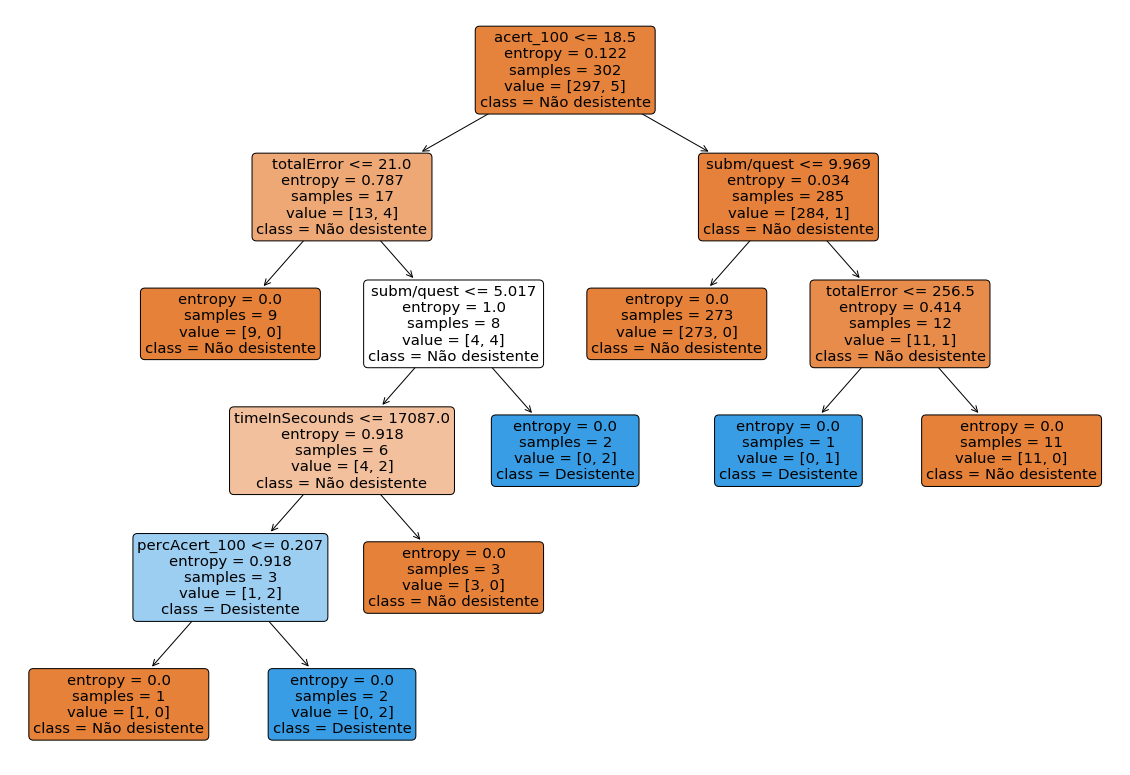

In [16]:
bx = df_list4.drop(['class_id', 'user_id', 'desistente', 'ateLista'], axis=1)
bx = bx.columns.tolist()

plt.figure(figsize=(20, 14))

plot_tree(dt_model, filled=True, rounded=True,class_names=['Não desistente','Desistente',],feature_names=bx)

plt.show()